In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


#PCA

In [2]:
from sklearn.decomposition import PCA

def pca_to_62x62(input_data):

    pca = PCA(n_components=50)
    transformed_data = pca.fit_transform(input_data)
    return transformed_data


#Rescaling


In [3]:
import numpy as np

def rescale_to_0_255(data):

    # Find the minimum and maximum values in the data
    min_val = data.min()
    max_val = data.max()

    # Perform min-max scaling to rescale the data to [0, 255]
    scaled_data = 255 * (data - min_val) / (max_val - min_val)

    return scaled_data.astype(np.uint8)  # Ensure the data type is uint8 for image representation


In [4]:
def zscale_row_wise(data):
    scaler = StandardScaler()
    dataz = scaler.fit_transform(data.T).T
    return dataz


In [5]:
!pip install numpy pandas scipy scikit-learn


# Data transformation for noise reduction and dimensionality reduction along with reshaping

In [6]:
import os
import numpy as np
from scipy.io import loadmat
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the directory path where the .mat files are located
base_dir = '/content/drive/MyDrive/SEED_IV/SEED_IV/eeg_feature_smooth'

# Set the batch size
batch_size = 96  # Adjust as needed

# Initialize an empty DataFrame
final_df = pd.DataFrame()


# Function to convert a 3D matrix to a 2D matrix
def convert_to_2d(matrix):
    return matrix.reshape((matrix.shape[0],-1))

# Traverse through the directories and load .mat files
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)

    if os.path.isdir(folder_path):
        # Initialize a list to store DataFrames for each batch
        batch_dfs = []

        for file in os.listdir(folder_path):
            if file.endswith('.mat'):
                file_path = os.path.join(folder_path, file)
                data = loadmat(file_path)  # Load .mat file


                # Extract subject number from the file name
                subject_number_str = file.split('_')[0]


                # Try to extract the last two digits; if there's an error, use the last one digit
                try:
                    subject_number = int(subject_number_str[-2:])
                except ValueError:
                    subject_number = int(subject_number_str[-1])

                # Initialize a DataFrame for each batch
                batch_df = pd.DataFrame()

                # Extract and process variables for each subject
                for prefix in ['de_LDS', 'de_movingAve', 'psd_LDS', 'psd_movingAve']:
                    for i in range(1, 25):  # Subject numbers range from 1 to 24
                        var_key = f'{prefix}{i}'
                        if var_key in data:
                            # Get the 3D matrix and convert to 2D
                            matrix_2d = convert_to_2d(data[var_key])
                            column_name = f'{folder}_{subject_number}_{i if i >= 10 else f"0{i}"}'

                            # Create a new column in the DataFrame and assign the variable
                            batch_df[column_name] = [matrix_2d]

                batch_dfs.append(batch_df)

                # Process the batch once it reaches the specified batch size
                if len(batch_dfs) >= batch_size:
                    batch_df = pd.concat(batch_dfs, axis=1)

                    # Apply PCA and rescaling to the batch (if needed)
                    batch_df = batch_df.applymap(zscale_row_wise)
                    batch_df = batch_df.applymap(pca_to_62x62)
                    # batch_df = batch_df.applymap(rescale_to_0_255)

                    # Append the batch to the final DataFrame
                    final_df = pd.concat([final_df, batch_df], axis=1)
                    batch_dfs = []

        # Process any remaining data in the last batch
        if len(batch_dfs) > 0:

            batch_df = pd.concat(batch_dfs, axis=1)

            # Apply PCA and rescaling to the last batch (if needed)
            batch_df = batch_df.applymap(zscale_row_wise)
            batch_df = batch_df.applymap(pca_to_62x62)
            # batch_df = batch_df.applymap(rescale_to_0_255)

            # Append the last batch to the final DataFrame
            final_df = pd.concat([final_df, batch_df], axis=1)

            # Print information after processing the last batch
            print(f"Shape of final_df after processing the last batch: {final_df.shape}")


Shape of final_df after processing the last batch: (1, 360)
Shape of final_df after processing the last batch: (1, 720)
Shape of final_df after processing the last batch: (1, 1080)


In [7]:
# import os
# import numpy as np
# from scipy.io import loadmat
# import pandas as pd
# import matplotlib.pyplot as plt

# # Define the directory path where the .mat files are located
# base_dir = '/content/drive/MyDrive/SEED_IV/SEED_IV/eeg_raw_data'

# # Initialize lists to store the shapes of the original data and the corresponding folder
# original_data_shapes = []
# y_axis_sizes = []

# # Traverse through the directories and load .mat files
# for folder in os.listdir(base_dir):
#     folder_path = os.path.join(base_dir, folder)

#     if os.path.isdir(folder_path):
#         for file in os.listdir(folder_path):
#             if file.endswith('.mat'):
#                 file_path = os.path.join(folder_path, file)
#                 data = loadmat(file_path)  # Load .mat file

#                 # Loop through variables in the loaded .mat file
#                 for var_key, var_value in data.items():
#                     # Skip variables that start with double underscores "__"
#                     if var_key.startswith("__"):
#                         continue

#                     # Get the shape of the original data
#                     original_shape = var_value.shape
#                     original_data_shapes.append((folder, var_key, original_shape))
#                     y_axis_sizes.append(original_shape[1])

# # Plot the Y-axis (timestamp) sizes
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(y_axis_sizes)), y_axis_sizes)
# plt.xlabel("Data Point")
# plt.ylabel("Y-Axis Size (Timestamp)")
# plt.title("Range of Y-Axis Sizes")
# plt.show()

# min_y_axis_size = min(y_axis_sizes)
# max_y_axis_size = max(y_axis_sizes)

# print(f"Minimum Y-Axis (Timestamp) Size: {min_y_axis_size}")
# print(f"Maximum Y-Axis (Timestamp) Size: {max_y_axis_size}")


In [8]:
final_df.head()  # Displays the first 5 rows



,2_12_01,2_12_02,2_12_03,2_12_04,2_12_05,2_12_06,2_12_07,2_12_08,2_12_09,2_12_10,...,1_9_15,1_9_16,1_9_17,1_9_18,1_9_19,1_9_20,1_9_21,1_9_22,1_9_23,1_9_24
0,"[[12.792097580403837, -1.3060728479559491, 1.8...","[[6.822028610551412, 1.3211406767576284, 0.040...","[[-3.7137825310821504, 3.5219994911550305, 0.8...","[[2.087015763101888, 4.4674758831613, 1.730615...","[[4.396613267401508, 0.008234087182706773, -2....","[[-3.452924679815366, -0.5813518594812717, 1.2...","[[0.34878669424985626, 0.8031101543510984, 3.9...","[[-2.381843671451097, 5.732114797081804, -2.31...","[[-3.968700630554607, -4.21803023488748, -0.46...","[[5.190164208642543, -0.7302970673168835, -0.7...",...,"[[2.628569286338972, -4.038167903798695, 2.362...","[[0.7749714842715524, 4.000269484026803, -0.06...","[[4.369221125105782, 0.15197206281358408, -1.2...","[[2.7341397588383183, -1.2958931836590417, 5.6...","[[-5.46086574919813, -1.17021163218289, -0.145...","[[-1.2901284495747765, 1.7665126954980437, -0....","[[-4.214099334059905, -1.0086167951239116, -2....","[[-1.6838247767275316, 2.128436423326539, -2.5...","[[5.309408701152228, 1.0143431968206478, -1.91...","[[-2.8014382091480066, 3.8191277603387253, 1.5..."


In [9]:
value = final_df.iloc[0, 1077]
print("value:", value)


value: [[-1.68382478e+00  2.12843642e+00 -2.58159484e+00 ... -5.23891820e-05
  -7.92783571e-04  4.02956074e-04]
 [ 2.58748833e+00  3.09273732e+00 -3.43131609e+00 ...  1.10656017e-04
   6.47473871e-04 -3.81685773e-04]
 [ 5.34984454e+00  1.06050732e+00 -2.07991662e+00 ...  2.40174032e-04
  -4.86764961e-04  1.34882437e-04]
 ...
 [-7.79578670e-01  1.31768179e+00  9.03669164e-01 ...  4.26967891e-03
  -3.19893241e-03 -2.35361698e-03]
 [-4.28505215e+00  1.32745464e+00  3.80503007e-01 ... -3.98609060e-03
   1.59890739e-03 -2.49849487e-03]
 [-4.32635844e+00  1.35498556e+00  3.80728124e-01 ...  1.22471652e-03
  -3.28230681e-03  4.42656574e-03]]


In [10]:
value = final_df.iloc[0, 1077]
print("value:", value.shape)


value: (62, 50)


#Labelling

In [11]:
#  labels
session1_label = [1, 2, 3, 0, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2, 3, 2, 2, 3, 3, 0, 3, 0, 3]
session2_label = [2, 1, 3, 0, 0, 2, 0, 2, 3, 3, 2, 3, 2, 0, 1, 1, 2, 1, 0, 3, 0, 1, 3, 1]
session3_label = [1, 2, 2, 1, 3, 3, 3, 1, 1, 2, 1, 0, 2, 3, 3, 0, 2, 3, 0, 0, 2, 0, 1, 0]

#  DataFrame column names
column_names = final_df.columns

# Add a new row for emotion labels
final_df.loc['Emotion_Label'] = [
    session1_label[int(i) - 1] if folder == '1' else
    session2_label[int(i) - 1] if folder == '2' else
    session3_label[int(i) - 1] if folder == '3' else 20
    for folder, _, i in [name.split('_') for name in column_names]
]


In [12]:
# Convert labels to integers
label_mapping = {'Class 0': 0, 'Class 1': 1, 'Class 2': 2, 'Class 3': 3}
final_df = final_df.replace({'Emotion_Label': label_mapping})

In [13]:
final_df.head()  # Displays the first 5 rows


,2_12_01,2_12_02,2_12_03,2_12_04,2_12_05,2_12_06,2_12_07,2_12_08,2_12_09,2_12_10,...,1_9_15,1_9_16,1_9_17,1_9_18,1_9_19,1_9_20,1_9_21,1_9_22,1_9_23,1_9_24
0,"[[12.792097580403837, -1.3060728479559491, 1.8...","[[6.822028610551412, 1.3211406767576284, 0.040...","[[-3.7137825310821504, 3.5219994911550305, 0.8...","[[2.087015763101888, 4.4674758831613, 1.730615...","[[4.396613267401508, 0.008234087182706773, -2....","[[-3.452924679815366, -0.5813518594812717, 1.2...","[[0.34878669424985626, 0.8031101543510984, 3.9...","[[-2.381843671451097, 5.732114797081804, -2.31...","[[-3.968700630554607, -4.21803023488748, -0.46...","[[5.190164208642543, -0.7302970673168835, -0.7...",...,"[[2.628569286338972, -4.038167903798695, 2.362...","[[0.7749714842715524, 4.000269484026803, -0.06...","[[4.369221125105782, 0.15197206281358408, -1.2...","[[2.7341397588383183, -1.2958931836590417, 5.6...","[[-5.46086574919813, -1.17021163218289, -0.145...","[[-1.2901284495747765, 1.7665126954980437, -0....","[[-4.214099334059905, -1.0086167951239116, -2....","[[-1.6838247767275316, 2.128436423326539, -2.5...","[[5.309408701152228, 1.0143431968206478, -1.91...","[[-2.8014382091480066, 3.8191277603387253, 1.5..."
Emotion_Label,2,1,3,0,0,2,0,2,3,3,...,2,3,2,2,3,3,0,3,0,3


#Data split

In [14]:
# import numpy as np

# # Extract the data and labels
# Image_Matrix = final_df.iloc[0, :].to_list()
# Label = final_df.iloc[1, :].to_list()

# # Define X as the input data (images)
# X = np.array(Image_Matrix).reshape(-1, 62, 50, 1)

# # Define y as the labels
# y = np.array(Label)

# # Split the data into training, validation, and test sets
# from sklearn.model_selection import train_test_split
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)



In [15]:
# print("Data types and shapes:")
# print("X_train:", type(X_train), X_train.shape if hasattr(X_train, 'shape') else None)
# print("X_val:", type(X_val), X_val.shape if hasattr(X_val, 'shape') else None)
# print("X_test:", type(X_test), X_test.shape if hasattr(X_test, 'shape') else None)
# print("y_train:", type(y_train), y_train.shape if hasattr(y_train, 'shape') else None)
# print("y_val:", type(y_val), y_val.shape if hasattr(y_val, 'shape') else None)
# print("y_test:", type(y_test), y_test.shape if hasattr(y_test, 'shape') else None)

# # Check the data type of the first element in X_train
# if len(X_train) > 0:
#     print("Data type of the first element in X_train:", type(X_train[0]))
# else:
#     print("X_train is empty.")

# # Check the data type of the first element in y_train
# if len(y_train) > 0:
#     print("Data type of the first element in y_train:", type(y_train[0]))
# else:
#     print("y_train is empty.")


In [16]:
# print(X_train.dtype)

In [17]:
# print(y_train.dtype)

In [18]:
# X_train = X_train.numpy()
# y_train = y_train.numpy()
# X_val = X_val.numpy()
# y_val = y_val.numpy()
# X_test = X_test.numpy()
# y_test = y_test.numpy()


In [22]:
# import matplotlib.pyplot as plt

# # Visualize some EEG data samples
# sample_indices = [0, 1, 2]
# for index in sample_indices:
#     sample_image = X_train[index].reshape(62, 50)
#     label = y_train[index]

#     plt.figure()
#     plt.imshow(sample_image, cmap='viridis')
#     plt.title(f"Sample EEG Data - Label: {label}")
#     plt.show()


# CNN model



Fold 1:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.6779 - accuracy: 0.2685

Fold 2:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.8387 - accuracy: 0.2685

Fold 3:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.5861 - accuracy: 0.3796

Fold 4:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.5449 - accuracy: 0.3241

Fold 5:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 6ms/step - loss: 1.7545 - accuracy: 0.3611


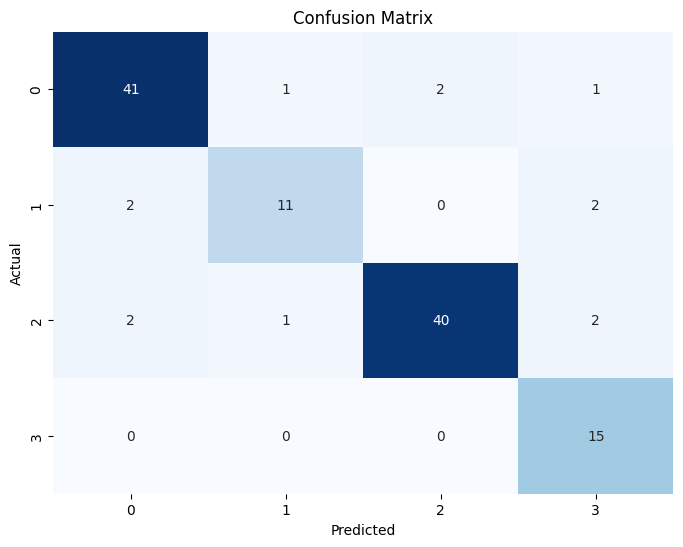

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming Image_Matrix and Label are your DataFrames
# Extract the data and labels
Image_Matrix = final_df.iloc[0, :].to_list()
Label = final_df.iloc[1, :].to_list()

# Define X as the input data (images)
X = np.array(Image_Matrix).reshape(-1, 62, 50, 1)

# Define y as the labels
y = np.array(Label)

# Calculate the index to split at
split_index = int(len(X) * (2/3))

# Assuming X and y are your data and labels
# Define the size of the training set
train_size = 16

# Define the size of the testing set
test_size = 8

# Define the starting index for the pattern
start_index = 0

# Define the ending index for the pattern (720 in this case)
end_index = 359

# Initialize empty lists to store training and testing indices
train_indices = []
test_indices = []

# Populate the training and testing indices based on the described pattern
for i in range(start_index, min(end_index, len(X)), train_size + test_size):
    train_indices.extend(range(i - train_size, i))
    test_indices.extend(range(i, i + test_size))

# Extract training and testing data based on the indices
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Further split the training data into training (50%) and validation (50%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=None)
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Feature and label matrices
X = np.array(Image_Matrix).reshape(-1, 62, 50, 1)
y = np.array(Label)

# Set the number of folds
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the results for each fold
all_train_acc = []
all_val_acc = []

# Loop through the folds
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    print(f"\nFold {fold}:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

    # Create and compile the model
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(62, 50, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), verbose=0)

    # Evaluate on training and validation sets
    train_loss, train_acc = model.evaluate(X_train, y_train)
    val_loss, val_acc = model.evaluate(X_val, y_val)

    # Append results to lists
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Calculate and print the average accuracy across folds
avg_train_acc = np.mean(all_train_acc)
avg_val_acc = np.mean(all_val_acc)
print(f'\nAverage Training Accuracy: {avg_train_acc}')
print(f'Average Validation Accuracy: {avg_val_acc}')

# Assuming X_test and y_test are your test data
X_test = np.array(X_test).reshape(-1, 62, 50, 1)
y_test = np.array(y_test)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Display the model summary
model.summary()

# Visualize the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



Fold 1:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.7687 - accuracy: 0.2500

Fold 2:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 5ms/step - loss: 1.7306 - accuracy: 0.2593

Fold 3:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.6599 - accuracy: 0.3796

Fold 4:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.6260 - accuracy: 0.3426

Fold 5:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.7392 - accuracy: 0.3148


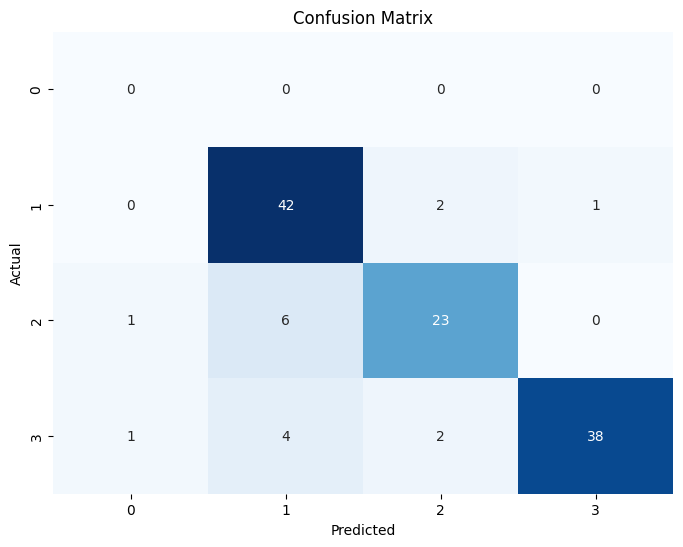

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming Image_Matrix and Label are your DataFrames
# Extract the data and labels
Image_Matrix = final_df.iloc[0, :].to_list()
Label = final_df.iloc[1, :].to_list()

# Define X as the input data (images)
X = np.array(Image_Matrix).reshape(-1, 62, 50, 1)

# Define y as the labels
y = np.array(Label)

# Calculate the index to split at
split_index = int(len(X) * (2/3))

# Assuming X and y are your data and labels
# Define the size of the training set
train_size = 16

# Define the size of the testing set
test_size = 8

# Define the starting index for the pattern
start_index = 360

# Define the ending index for the pattern (720 in this case)
end_index = 719

# Initialize empty lists to store training and testing indices
train_indices = []
test_indices = []

# Populate the training and testing indices based on the described pattern
for i in range(start_index, min(end_index, len(X)), train_size + test_size):
    train_indices.extend(range(i - train_size, i))
    test_indices.extend(range(i, i + test_size))

# Extract training and testing data based on the indices
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Further split the training data into training (50%) and validation (50%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=None)


import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Feature and label matrices
X = np.array(Image_Matrix).reshape(-1, 62, 50, 1)
y = np.array(Label)

# Set the number of folds
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the results for each fold
all_train_acc = []
all_val_acc = []

# Loop through the folds
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    print(f"\nFold {fold}:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

    # Create and compile the model
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(62, 50, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), verbose=0)

    # Evaluate on training and validation sets
    train_loss, train_acc = model.evaluate(X_train, y_train)
    val_loss, val_acc = model.evaluate(X_val, y_val)

    # Append results to lists
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Calculate and print the average accuracy across folds
avg_train_acc = np.mean(all_train_acc)
avg_val_acc = np.mean(all_val_acc)
print(f'\nAverage Training Accuracy: {avg_train_acc}')
print(f'Average Validation Accuracy: {avg_val_acc}')

# Assuming X_test and y_test are your test data
X_test = np.array(X_test).reshape(-1, 62, 50, 1)
y_test = np.array(y_test)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Display the model summary
model.summary()

# Visualize the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



Fold 1:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.7382 - accuracy: 0.3241

Fold 2:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.9906 - accuracy: 0.2315

Fold 3:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 6ms/step - loss: 1.5004 - accuracy: 0.3241

Fold 4:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 6ms/step - loss: 1.3938 - accuracy: 0.3611

Fold 5:
X_train shape: (972, 62, 50, 1), y_train shape: (972,)
X_val shape: (108, 62, 50, 1), y_val shape: (108,)
4/4 [==============================] - 0s 4ms/step - loss: 1.9168 - accuracy: 0.2130


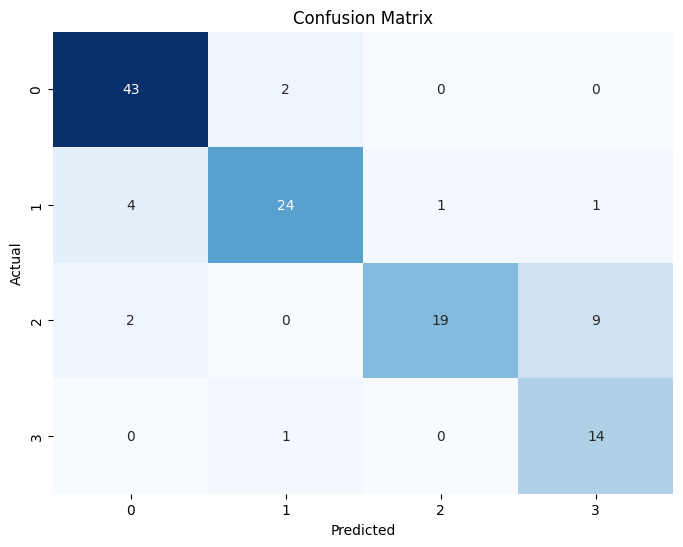

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming Image_Matrix and Label are your DataFrames
# Extract the data and labels
Image_Matrix = final_df.iloc[0, :].to_list()
Label = final_df.iloc[1, :].to_list()

# Define X as the input data (images)
X = np.array(Image_Matrix).reshape(-1, 62, 50, 1)

# Define y as the labels
y = np.array(Label)

# Calculate the index to split at
split_index = int(len(X) * (2/3))

# Assuming X and y are your data and labels
# Define the size of the training set
train_size = 16

# Define the size of the testing set
test_size = 8

# Define the starting index for the pattern
start_index = 720

# Define the ending index for the pattern (720 in this case)
end_index = 1079

# Initialize empty lists to store training and testing indices
train_indices = []
test_indices = []

# Populate the training and testing indices based on the described pattern
for i in range(start_index, min(end_index, len(X)), train_size + test_size):
    train_indices.extend(range(i - train_size, i))
    test_indices.extend(range(i, i + test_size))

# Extract training and testing data based on the indices
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Further split the training data into training (50%) and validation (50%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=None)

import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Feature and label matrices
X = np.array(Image_Matrix).reshape(-1, 62, 50, 1)
y = np.array(Label)

# Set the number of folds
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the results for each fold
all_train_acc = []
all_val_acc = []

# Loop through the folds
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    print(f"\nFold {fold}:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

    # Create and compile the model
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(62, 50, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), verbose=0)

    # Evaluate on training and validation sets
    train_loss, train_acc = model.evaluate(X_train, y_train)
    val_loss, val_acc = model.evaluate(X_val, y_val)

    # Append results to lists
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

# Calculate and print the average accuracy across folds
avg_train_acc = np.mean(all_train_acc)
avg_val_acc = np.mean(all_val_acc)
print(f'\nAverage Training Accuracy: {avg_train_acc}')
print(f'Average Validation Accuracy: {avg_val_acc}')

# Assuming X_test and y_test are your test data
X_test = np.array(X_test).reshape(-1, 62, 50, 1)
y_test = np.array(y_test)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Display the model summary
model.summary()

# Visualize the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


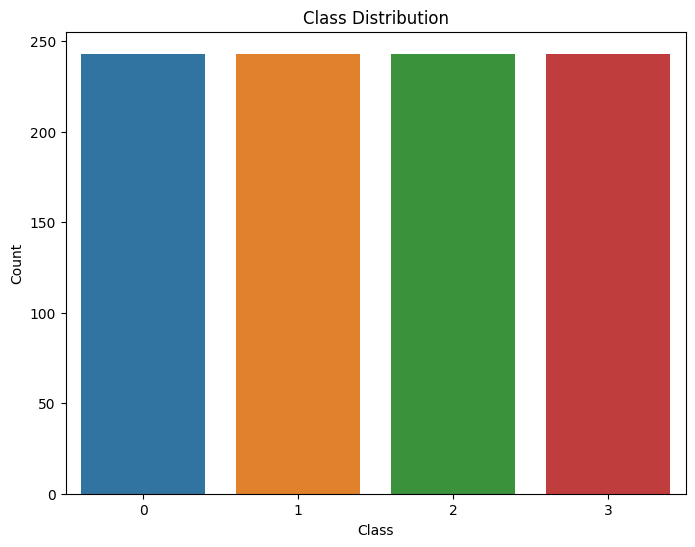

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_train contains your class labels
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()



In [32]:
mean=(0.8916666507720947+0.8583333492279053+0.8333333134651184)/3
print(mean)

0.8611111044883728
